## Data description

There are 3 types of input features:

    Objective: factual information;
    Examination: results of medical examination;
    Subjective: information given by the patient.

Features:

    Age | Objective Feature | age | int (days)
    Height | Objective Feature | height | int (cm) |
    Weight | Objective Feature | weight | float (kg) |
    Gender | Objective Feature | gender | categorical code |
    Systolic blood pressure | Examination Feature | ap_hi | int |
    Diastolic blood pressure | Examination Feature | ap_lo | int |
    Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
    Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
    Smoking | Subjective Feature | smoke | binary |
    Alcohol intake | Subjective Feature | alco | binary |
    Physical activity | Subjective Feature | active | binary |
    Presence or absence of cardiovascular disease | Target Variable | cardio | binary | 0 = no 1= yes

All of the dataset values were collected at the moment of medical examination. 

## Initial data pre-processing

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly_express as px

In [67]:
df =  pd.read_csv("./Data/cardio_train.csv", sep = ";", index_col= "id")
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


From the dataset description we find out that the age is in days, which is not that convenient for me, so I will transform this into age in years. I will make a copy of the dataset for this purpose.

In [68]:
df_years = df.rename(columns = {"age": "age_days"})
df_years["age_years"] = df_years["age_days"]/365

df_years.drop(["age_days"], axis = 1, inplace = True)
df_years.head()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
id,,,,,,,,,,,,
0,2,168,62.0,110,80,1,1,0,0,1,0,50.391781
1,1,156,85.0,140,90,3,1,0,0,1,1,55.419178
2,1,165,64.0,130,70,3,1,0,0,0,1,51.663014
3,2,169,82.0,150,100,1,1,0,0,1,1,48.282192
4,1,156,56.0,100,60,1,1,0,0,0,0,47.873973


Examining data for being accurate and consistent.

In [69]:
df_years.describe()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700,53.339358
std,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003,6.759594
min,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,29.583562
25%,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,48.394521
50%,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,53.980822
75%,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,58.430137
max,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,64.967123


* Age range is 29 - 64 years; There is some strange height and weight data, which is actually possible if studying Guinness World Records Book, but can probably cause problems with regression. So, I want to compute the **leverage statistic** for these columns; if the leverage statistic is high, I will gather this data in a separate dataset, to study them separately (will do it when analyzing BMI)

* ap_hi cannot be as high as 16020 and as low as -150. Same with ap_lo, so we'll have to clean these as well;



In [70]:
x = [(x - 165)**2 for x in df["height"]]
ss = np.sum(x)
lev = 1/70000 + (195 - 165)**2/ss
norm_lev = 2/70000
print(lev, norm_lev)

# very high leverage statistic for height 55
# создать функцию, которая собирает данные с leverage > norm_lev * 3.5 в отдельный dataset

0.00020387490820723196 2.857142857142857e-05


In [71]:
df.isna().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [72]:
print (True in df.duplicated())

False


### Data Cleaning

Here I:
- have changed negative ap_hi and ap_lo to positive;
- have added "0" to the end of otherwise plausible ap_hi and ap_lo values (e.g. 12 -> 120);
- have removed ap_lo < 20 which didn't seem possible to correct by muliplying by 10;
- have removed the rows with ap_hi > 250, as I haven't found any pattern in this mistake;
- have removed the rows with ap_lo = 0;
- have removed an odd "0" from ap_lo > 200 (e.g. 1000 -> 100);
- plotted weights and heights and made a conclusion, that weights < 35 and heights <100 are not trustworthy in this dataset.


In [ ]:
df.loc[:, 'ap_hi']<30

In [ ]:
df.loc[df.loc[:, 'ap_hi']<0, :]

In [ ]:
df.loc[df.loc[:, 'ap_hi']<0, 'ap_hi']

In [ ]:
for x in df.loc[df.loc[:, 'ap_hi']<0, 'ap_hi']:
    df.loc[df.loc[:, 'ap_hi']<0, 'ap_hi'] = abs(x)

df.loc[6525, :]


In [ ]:
df.loc[df.loc[:, 'ap_hi']<25, :]

In [78]:
for x in df.loc[df.loc[:, 'ap_hi']<25, 'ap_hi']:
    df.loc[df.loc[:, 'ap_hi']<25, 'ap_hi'] = x*10

In [ ]:
df.loc[df.loc[:, 'ap_hi']<60, :]

In [ ]:
df.loc[df.loc[:, 'ap_hi']>250, :]

In [87]:
df.drop((df.loc[df.loc[:, 'ap_hi']>250, :]).index, inplace = True)

In [ ]:
df.describe()

In [ ]:
df.loc[df.loc[:, 'ap_lo']<0, :]

In [91]:
df.loc[df.loc[:, 'ap_lo']<0, 'ap_lo'] = 70

In [ ]:
df.loc[df.loc[:, 'ap_lo']==0, :]

In [95]:
df.drop((df.loc[df.loc[:, 'ap_lo']==0, :]).index, inplace = True)

In [ ]:
df.loc[df.loc[:, 'ap_lo']<20, :]

In [101]:
df.drop(labels = [50210, 81260, 91129], axis = 0, inplace = True)

In [103]:
for x in df.loc[df.loc[:, 'ap_lo']<20, 'ap_lo']:
    df.loc[df.loc[:, 'ap_lo']<20, 'ap_lo'] = x*10

In [ ]:
df.loc[df.loc[:, 'ap_lo']>200, :]

In [106]:
for x in df.loc[df.loc[:, 'ap_lo']>200, 'ap_lo']:
    df.loc[df.loc[:, 'ap_lo']>200, 'ap_lo'] = x/10

C:\Users\Mary\AppData\Local\Temp\ipykernel_6200\4219832870.py:2: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '103.3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



In [ ]:
df.describe()

In [110]:
px.scatter(df, x = "weight", y = "height", color = "cardio", color_continuous_scale="bluered")

Weight below 35 is most likely incorrect data gathering, as well as heights below 1 m

In [112]:
df.drop((df.loc[df.loc[:, 'weight']<35, :]).index, inplace = True)

In [113]:
df.drop((df.loc[df.loc[:, 'height']<100, :]).index, inplace = True)

In [115]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69894.000000,69894.000000,69894.000000,69894.000000,69894.000000,69894.000000,69894.000000,69894.000000,69894.000000,69894.000000,69894.000000,69894.000000
mean,19469.161516,1.349587,164.400406,74.219657,127.035568,81.761782,1.366956,1.226572,0.088176,0.053767,0.803674,0.499714
std,2466.982884,0.476843,7.990043,14.360540,17.087656,10.231216,0.680355,0.572377,0.283553,0.225559,0.397221,0.500003
min,10798.000000,1.000000,100.000000,35.000000,60.000000,20.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17665.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,240.000000,190.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Now the data looks much better, being more or less clean.

## Exploratory Data Analysis

In [116]:
import seaborn as sns

In [118]:
df["cardio"].value_counts()

cardio
0    34967
1    34927
Name: count, dtype: int64

<Axes: xlabel='cardio', ylabel='count'>

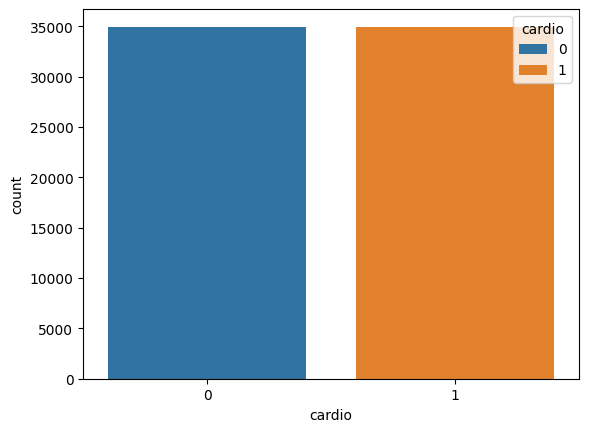

In [131]:
sns.countplot(df, x = "cardio", hue = "cardio")

The dataset looks pretty balanced.